    ESS   Eta  Dprate  Cap  Capinitial
0  ESS1  0.95     0.5  2.1        0.42
1  ESS2  0.95     0.5  1.9        0.38
2  ESS3  0.95     0.5  1.2        0.24
3  ESS4  0.95     0.5  2.2        0.44
4  ESS5  0.95     0.5  1.4        0.28


<Axes: xlabel='Time_Step', ylabel='P_Load'>

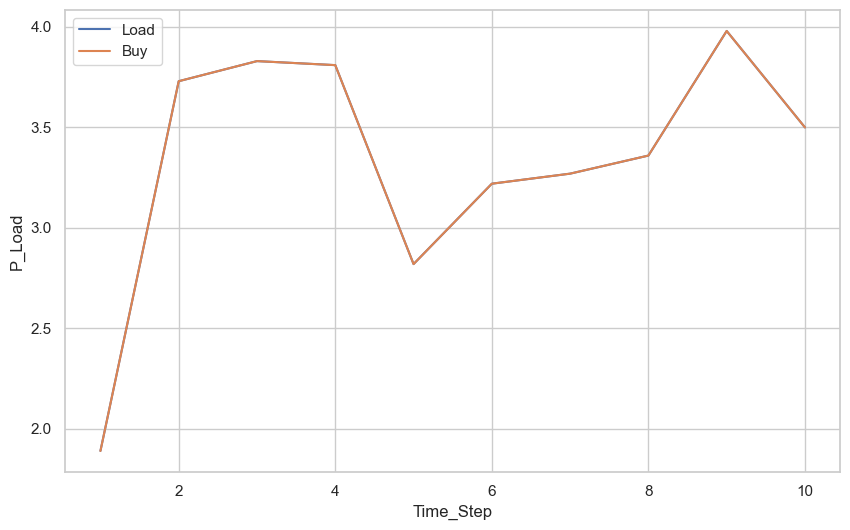

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar os dados (exemplo simulado, substituir pelos dados reais)
sample_data = pd.DataFrame({
    "ESS": ["ESS1", "ESS2", "ESS3", "ESS4", "ESS5"],
    "Eta": [0.95, 0.95, 0.95, 0.95, 0.95],#eficiencia
    "Dprate": [0.50, 0.50, 0.50, 0.50, 0.50],#max charge and discharge
    "Cap": [2.10, 1.90, 1.20, 2.20, 1.40],#capacity kw/h 
    "Capinitial": [0.42, 0.38, 0.24, 0.44, 0.28] #initial capacity
})

detailed_results = pd.DataFrame({
    "Day": np.ones(10),
    "Time_Step": np.arange(1, 11),
    "Prosumer": np.ones(10),
    "P_buy": [1.89, 3.73, 3.83, 3.81, 2.82, 3.22, 3.27, 3.36, 3.98, 3.50],
    "P_sell": np.zeros(10),
    "SOC": np.ones(10) * 0.42, #state of charge
    "P_ESS_ch": np.zeros(10), #power used for each  charge
    "P_ESS_dch": np.zeros(10),#power used for each  discharge
    "P_PV_load": np.zeros(10),# power used for each load () kw
    "P_PV_ESS": np.zeros(10), #power used from pv to ess
    "P_Peer_out": np.zeros(10), #power given exchange between prosumers    
    "P_Peer_in": np.zeros(10), #power received exchange between prosumers
    "P_Load": [1.89, 3.73, 3.83, 3.81, 2.82, 3.22, 3.27, 3.36, 3.98, 3.50] #power used for each load () kw (exchange)
})

print(sample_data)


# Plotar gráfico
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=detailed_results, x="Time_Step", y="P_Load", label="Load", ax=ax)
sns.lineplot(data=detailed_results, x="Time_Step", y="P_buy", label="Buy", ax=ax)


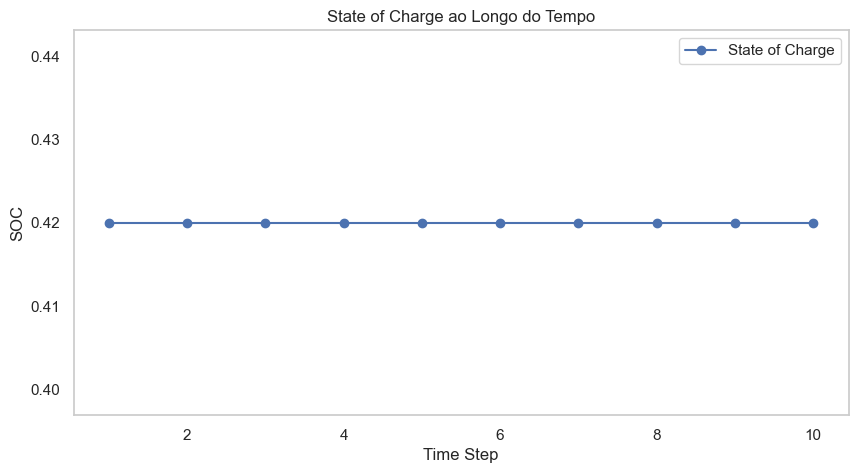

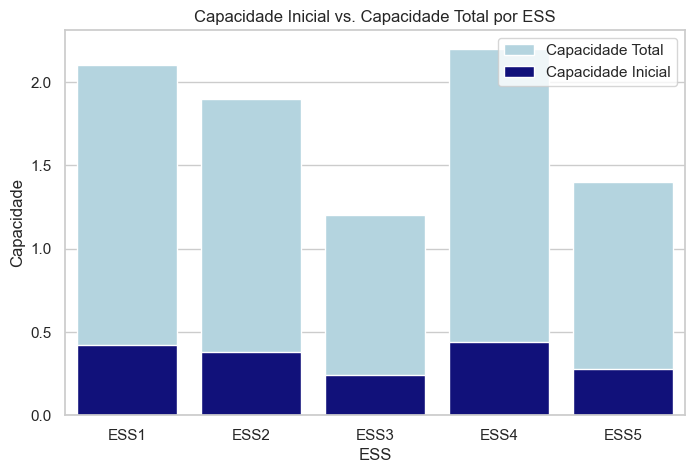

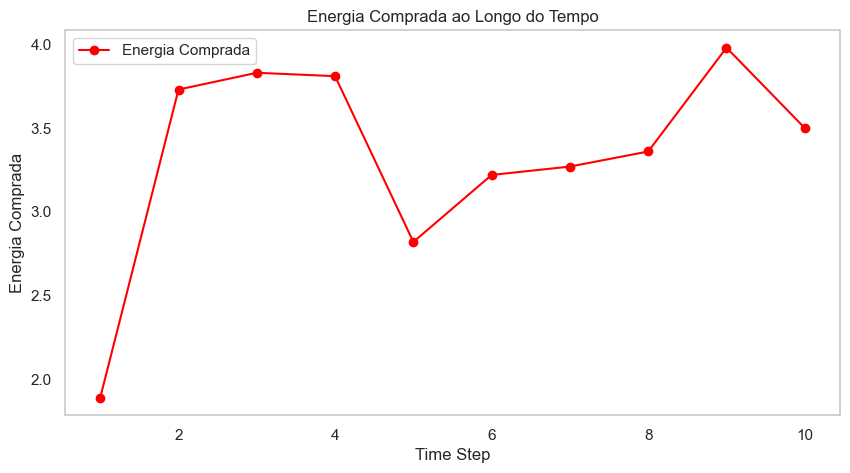

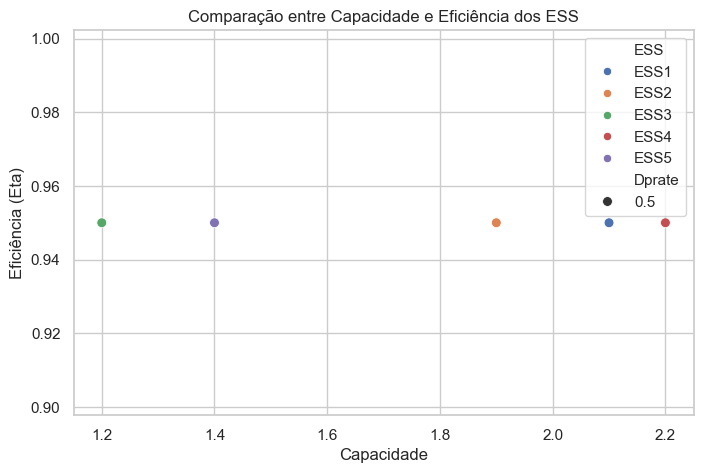

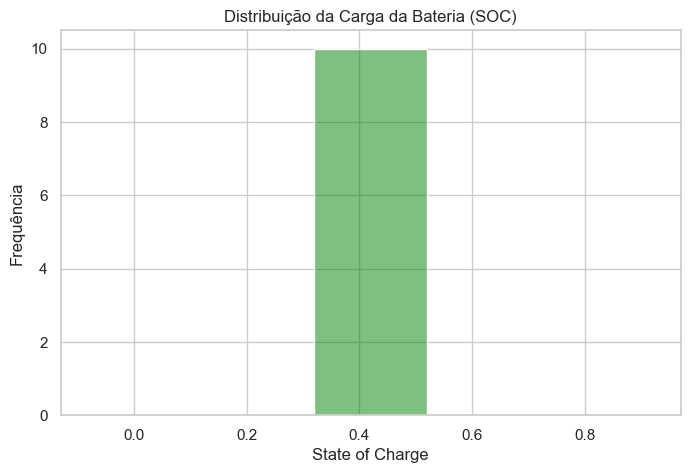

In [ ]:
# Gráfico 1: SOC ao longo do tempo
plt.figure(figsize=(10, 5))
plt.plot(df["Time_Step"], df["SOC"], marker='o', label='State of Charge')
plt.xlabel("Time Step")
plt.ylabel("SOC")
plt.title("State of Charge ao Longo do Tempo")
plt.legend()
plt.grid()
plt.show()

# Gráfico 2: Capacidade Inicial vs. Capacidade Total
plt.figure(figsize=(8, 5))
sns.barplot(x="ESS", y="Cap", data=sample_data, color="lightblue", label="Capacidade Total")
sns.barplot(x="ESS", y="Capinitial", data=sample_data, color="darkblue", label="Capacidade Inicial")
plt.ylabel("Capacidade")
plt.title("Capacidade Inicial vs. Capacidade Total por ESS")
plt.legend()
plt.show()

# Gráfico 3: Energia Comprada ao Longo do Tempo
plt.figure(figsize=(10, 5))
plt.plot(df["Time_Step"], df["P_buy"], marker='o', color='red', label='Energia Comprada')
plt.xlabel("Time Step")
plt.ylabel("Energia Comprada")
plt.title("Energia Comprada ao Longo do Tempo")
plt.legend()
plt.grid()
plt.show()

# Gráfico 4: Comparação de Eficiência e Capacidade dos ESS
plt.figure(figsize=(8, 5))
sns.scatterplot(x="Cap", y="Eta", size="Dprate", hue="ESS", data=sample_data, sizes=(50, 200))
plt.xlabel("Capacidade")
plt.ylabel("Eficiência (Eta)")
plt.title("Comparação entre Capacidade e Eficiência dos ESS")
plt.legend()
plt.show()

# Gráfico 5: Distribuição da Carga da Bateria
plt.figure(figsize=(8, 5))
sns.histplot(detailed_results_df_df_df["SOC"], kde=True, bins=5, color='green')
plt.xlabel("State of Charge")
plt.ylabel("Frequência")
plt.title("Distribuição da Carga da Bateria (SOC)")
plt.show()


In [2]:
from scipy.optimize import newton_krylov
from pyomo.environ import SolverFactory, SolverManagerFactory
from pyomo.environ import*
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pulp import LpVariable, LpMinimize, LpProblem, lpSum, value, GUROBI, GLPK_CMD
import envs as en
import pyomo.contrib.solver.ipopt
import os
from pyomo.environ import value

# Load data
file_path = "sampledata.xlsx"
sample_data = pd.read_excel(file_path, header=None, sheet_name=None)

PPV_capacity =sample_data['PPV_capacity']   #  Capacidade máxima de geração de energia fotovoltaica por hora
 
PLoad=sample_data['PL']              # Perfil de carga dos consumidores ao longo do dia 

Cbuy=(sample_data['buysell'])[1]         # The price of electricity bought from the grid

Csell=(sample_data['buysell'])[2]         # The price of electricity sold to the grid

ESSparam=(sample_data['ESS-Param'])      # Energy Storage System parameters

ΔT = 0.25  # Time interval (e.g., 15-minute periods)

# Model Definition

nPlayers=len(PLoad.loc[1,:])-1
Thorizon = 96  # Periods per day
#Thorizon=len(PLoad.loc[:,1])-1
days = int(len(PLoad) / Thorizon)  # Number of days

# Initialize a dictionary to store results
SOC_end_of_day = {} # Final SOC for each ESS at the end of each day

detailed_results = [] 


total_objective_value =0    

################## Indexes ####################################################################################

for day in range(1, days + 1):
    print(f"Solving for Day {day}...")
    
    # Extract daily data
    start_idx = (day - 1) * Thorizon + 1
    end_idx = start_idx + Thorizon - 1
    PLoad_day = PLoad.loc[start_idx:end_idx, :]
    PPV_capacity_day = PPV_capacity.loc[start_idx:end_idx, :]
    Cbuy_day = Cbuy.loc[start_idx:end_idx]
    Csell_day = Csell.loc[start_idx:end_idx]   

    model=AbstractModel()    
# Define sets
    model.PL = RangeSet(nPlayers)                      # Prosumers
    model.T = RangeSet(Thorizon)                       # Time Horizon
    model.ESS1 =  RangeSet(len(ESSparam.loc[:,1])-1)              # Energy Storage Systems


    #Load profile
    model.PLs=Param(model.T,model.PL,initialize=lambda model,r,c:PLoad.at[r,c], within=Reals) 
    #PV generation  
    model.PPV_capacitys=Param(model.T,model.PL,initialize=lambda model,r,c:PPV_capacity.at[r,c], within=Reals)
    model.Cbuys=Param(model.T,initialize=lambda model,r:Cbuy.at[r], within=Reals)
    model.Csells=Param(model.T,initialize=lambda model,r:Csell.at[r], within=Reals)
    #Soterage system parameters
    model.ESSparams=Param(model.ESS1,model.PL,initialize=lambda model,r,c:ESSparam.at[r,c], within=Reals)



# Variables to model consume, buy, sell, and storage
    model.P_ESS_s = Var(model.PL, model.T, within=NonNegativeReals)  # ESS state of charge
    model.P_ESS_ch = Var(model.PL, model.T, within=NonNegativeReals)  # ESS charging
    model.P_ESS_dch = Var(model.PL, model.T, within=NonNegativeReals)  # ESS discharging
    model.I_ESS_ch = Var(model.PL, model.T, within=Binary)  # ESS charging binary
    model.I_ESS_dch = Var(model.PL, model.T, within=Binary)  # ESS discharging binary
    model.P_buy = Var(model.PL, model.T, within=NonNegativeReals)  # Power bought from the grid
    model.P_sell = Var(model.PL, model.T, within=NonNegativeReals)  # Power sold to the grid
    model.P_peer = Var(model.PL, model.PL, model.T, within=NonNegativeReals)
    

    model.P_PV_ESS = Var(model.PL, model.T, within=NonNegativeReals)  # PV used for charging battery
    model.P_PV_load = Var(model.PL, model.T, within=NonNegativeReals)  # PV used for direct load consumption






# Constraints to assure physical and operational rules
    def SocESS(model, PL, T):
        if T == 1:
            # Initial SOC set to the previous day's final SOC
            return model.P_ESS_s[PL, T] == (SOC_end_of_day.get((PL, day - 1), model.ESSparams[4, PL])
                                            + ΔT * (model.ESSparams[1, PL] * model.P_ESS_ch[PL, T]
                                                    - model.P_ESS_dch[PL, T] / model.ESSparams[1, PL]))
        else:
            return model.P_ESS_s[PL, T] == (model.P_ESS_s[PL, T - 1]
                                            + ΔT * (model.ESSparams[1, PL] * model.P_ESS_ch[PL, T]
                                                    - model.P_ESS_dch[PL, T] / model.ESSparams[1, PL]))

    model.c_SOC = Constraint(model.PL, model.T, rule=SocESS)

    def chargeESS1(model,PL,T):
    
            return model.P_ESS_ch[PL,T]<=model.ESSparams[2,PL]*model.ESSparams[3,PL]*model.I_ESS_ch[PL,T]
    
    model.c42=Constraint(model.PL,model.T,rule=chargeESS1) #  ESS constraints


    def dischargeESS1(model,PL,T):
    
            return model.P_ESS_dch[PL,T]<=model.ESSparams[2,PL]*model.ESSparams[3,PL]*model.I_ESS_dch[PL,T]
    
    model.c43=Constraint(model.PL,model.T,rule=dischargeESS1) #  ESS constraints


    def chargedischargeESS(model,PL,T):
    
            return model.I_ESS_ch[PL,T]+model.I_ESS_dch[PL,T]<=1
    
    model.c44=Constraint(model.PL,model.T,rule=chargedischargeESS) #  ESS constraints

    def chargedischargelimit(model,PL):
    
            return sum( model.I_ESS_ch[PL,T]+model.I_ESS_dch[PL,T] for T in model.T) <=5
    
    model.c44=Constraint(model.PL,rule=chargedischargelimit) #  ESS constraints



    def load_balance(model, PL, T):
        return model.PLs[T, PL] == model.P_PV_load[PL, T] + model.P_buy[PL, T] - model.P_sell[PL, T] + model.P_ESS_dch[PL, T]  + sum(model.P_peer[PL2, PL, T] - model.P_peer[PL, PL2, T] for PL2 in model.PL if PL2 != PL)

    model.c_balance = Constraint(model.PL, model.T, rule=load_balance)

    def peer_transfer_limit(model, PL,  T):
            return sum(model.P_peer[PL, PL2, T] for PL2 in model.PL if PL2 != PL)<= max(0, model.PPV_capacitys[T, PL] - model.PLs[T, PL])
    model.c_peer = Constraint(model.PL,  model.T, rule=peer_transfer_limit)

    def PV_utilization(model, PL, T):
        return model.P_PV_ESS[PL, T] + model.P_PV_load[PL, T] == model.PPV_capacitys[T, PL]

    model.c_PV_utilization = Constraint(model.PL, model.T, rule=PV_utilization)
    def chargeESS2(model, PL, T):
        return model.P_ESS_ch[PL, T] == model.P_PV_ESS[PL, T]  # Battery charges only from PV

    model.c_ESS_PV_only = Constraint(model.PL, model.T, rule=chargeESS2)





    def enforce_battery_soc_limit(model, PL, T):
        """
        Prevents battery from discharging below SOC_min.
        """
        return model.P_ESS_s[PL, T] - ΔT * model.P_ESS_dch[PL, T] >= model.ESSparams[4,PL]
    model.c21=Constraint(model.PL,model.T,rule=enforce_battery_soc_limit) 



    def Pbuy11(model,PL,T):
    
        return model.P_buy[PL,T]<=12.5        #(sum(model.Pro_C[PL,NEC]*model.PV_connections[PL,PV]*model.PPV_capacitys[12,PV] for PV in model.PV  for PL in model.PL ))/1  
   
    model.c22=Constraint(model.PL,model.T,rule=Pbuy11) 


    def Psell11(model,PL,T):
    
        return model.P_sell[PL,T]<=10.5      #(sum(model.Pro_C[PL,NEC]*model.PV_connections[PL,PV]*model.PPV_capacitys[12,PV] for PV in model.PV  for PL in model.PL ))/1  
   
    model.c23=Constraint(model.PL,model.T,rule=Psell11) 




# Objective Function

    def rule_OF(model):
        return sum(
            (model.Cbuys[t] * model.P_buy[PL, t]  # ✅ Corrected indexing
             - model.Csells[t] * model.P_sell[PL, t])
            for t in model.T
            for PL in model.PL  # ✅ Correct iteration
            )

    model.Objective = Objective(rule=rule_OF, sense=minimize)


#model.c_SOC.deactivate()



    opt = SolverFactory('gurobi')



#opt.options['TimeLimit'] = 100000  # Set a time limit of 300 seconds
#opt.options['MIPGap'] = 0.01    # Set a MIP gap tolerance of 1%
    instance=model.create_instance() 
# Solve the model

    opt.options['Threads'] = 28       # Use 4 threads (adjust based on your hardware)
    opt.options['TimeLimit'] = 60000   # Set a time limit of 600 seconds (10 minutes)
#    opt.options['MIPGap'] = 0.00005     # Allow 1% optimality gap
#    opt.options['Heuristics'] = 0.3
# Solve and measure time

    results = opt.solve(instance)


    results.write()
    SOC_end_of_day.update({(PL, day): value(instance.P_ESS_s[PL, Thorizon]) for PL in model.PL})
    
    day_objective_value = value(instance.Objective)
    total_objective_value += day_objective_value
    
    

    for PL in model.PL:
        for t in model.T:
            detailed_results.append({
                "Day": day,
                "Time_Step": t,
                "Prosumer": PL,
                "P_buy": value(instance.P_buy[PL, t]),
                "P_sell": value(instance.P_sell[PL, t]),
                "SOC": value(instance.P_ESS_s[PL, t]),
                "P_ESS_ch": value(instance.P_ESS_ch[PL, t]),
                "P_ESS_dch": value(instance.P_ESS_dch[PL, t]),
                "P_PV_load": value(instance.P_PV_load[PL, t]),
                "P_PV_ESS": value(instance.P_PV_ESS[PL, t]),
                "P_Peer_out": sum(value(instance.P_peer[PL, PL2, t]) for PL2 in model.PL if PL2 != PL),
                "P_Peer_in": sum(value(instance.P_peer[PL2, PL, t]) for PL2 in model.PL if PL2 != PL),
                "P_Load": value(instance.PLs[t, PL])
                })

# Convert results to a DataFrame and save to Excel
detailed_results_df = pd.DataFrame(detailed_results)

detailed_results_path = r"detailed_results.xlsx"
detailed_results_df.to_excel(detailed_results_path, index=False)

# Carregar os dados (exemplo simulado, substituir pelos dados reais)
sample_data = pd.DataFrame({
    "ESS": ["ESS1", "ESS2", "ESS3", "ESS4", "ESS5"],
    "Eta": [0.95, 0.95, 0.95, 0.95, 0.95],
    "Dprate": [0.50, 0.50, 0.50, 0.50, 0.50],
    "Cap": [2.10, 1.90, 1.20, 2.20, 1.40],
    "Capinitial": [0.42, 0.38, 0.24, 0.44, 0.28]
})

print(f"Detailed results saved to: {detailed_results_path}")
print(f"Overall objective function value for all days: {total_objective_value:.2f}") 


Solving for Day 1...
'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>). This
is usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1
  Lower bound: 53286.64762509023
  Upper bound: 53290.97640124321
  Number of objectives: 1
  Number of constraints: 4805
  Number of variables: 6240
  Number of binary variables: 960
  Number of integer variables: 960
  Number of continuous variables: 5280
  Number of nonzeros: 16315
  Sense: minimize
# ------------------------------------------------

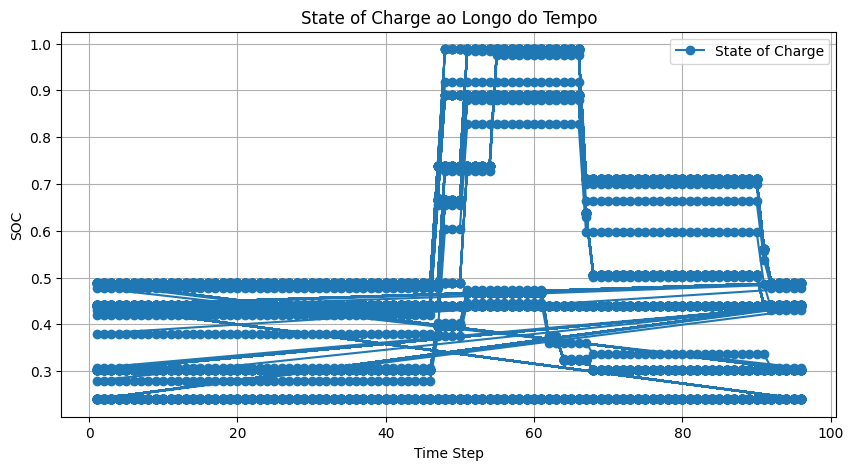

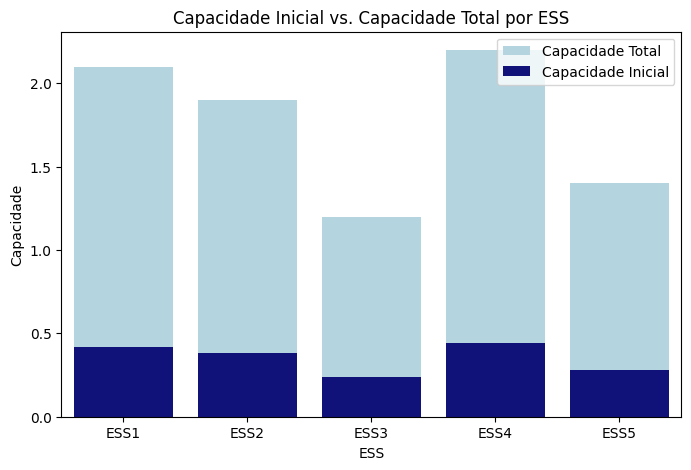

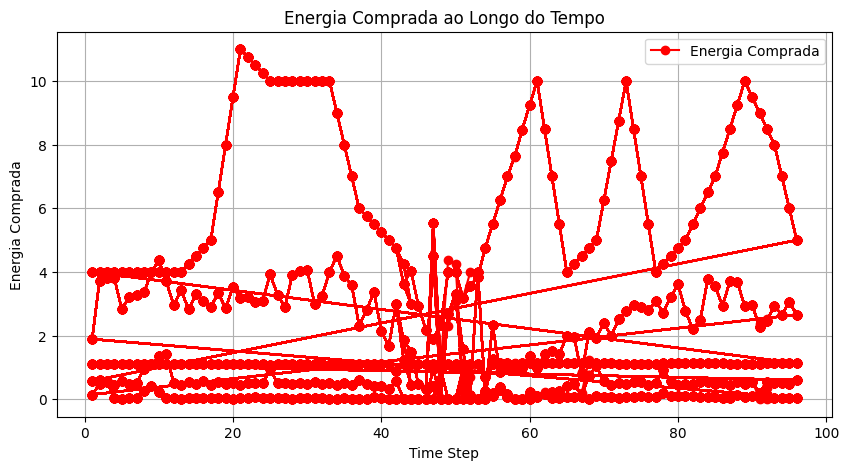

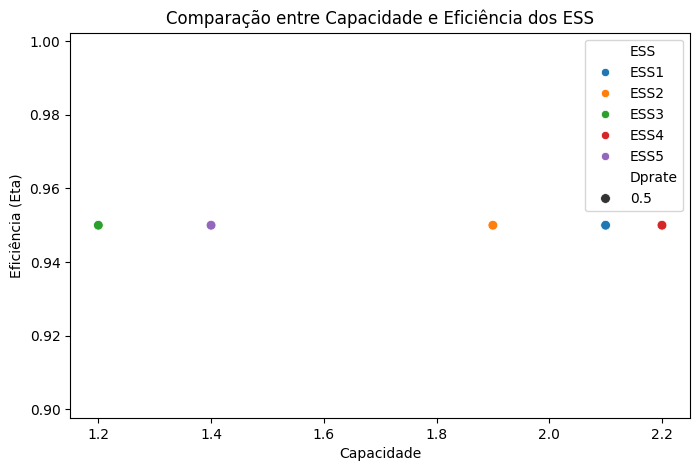

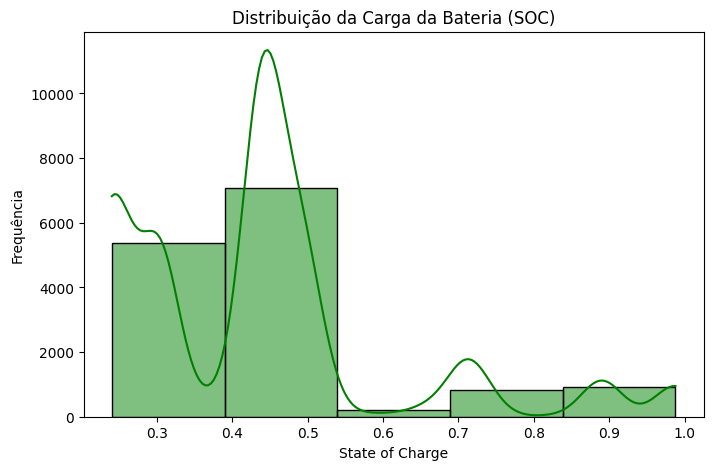

In [11]:
import seaborn as sns
# Gráfico 1: SOC ao longo do tempo
plt.figure(figsize=(10, 5))
plt.plot(detailed_results_df["Time_Step"], detailed_results_df["SOC"], marker='o', label='State of Charge')
plt.xlabel("Time Step")
plt.ylabel("SOC")
plt.title("State of Charge ao Longo do Tempo")
plt.legend()
plt.grid()
plt.show()

# Gráfico 2: Capacidade Inicial vs. Capacidade Total
plt.figure(figsize=(8, 5))
sns.barplot(x="ESS", y="Cap", data=sample_data, color="lightblue", label="Capacidade Total")
sns.barplot(x="ESS", y="Capinitial", data=sample_data, color="darkblue", label="Capacidade Inicial")
plt.ylabel("Capacidade")
plt.title("Capacidade Inicial vs. Capacidade Total por ESS")
plt.legend()
plt.show()

# Gráfico 3: Energia Comprada ao Longo do Tempo
plt.figure(figsize=(10, 5))
plt.plot(detailed_results_df["Time_Step"], detailed_results_df["P_buy"], marker='o', color='red', label='Energia Comprada')
plt.xlabel("Time Step")
plt.ylabel("Energia Comprada")
plt.title("Energia Comprada ao Longo do Tempo")
plt.legend()
plt.grid()
plt.show()

# Gráfico 4: Comparação de Eficiência e Capacidade dos ESS
plt.figure(figsize=(8, 5))
sns.scatterplot(x="Cap", y="Eta", size="Dprate", hue="ESS", data=sample_data, sizes=(50, 200))
plt.xlabel("Capacidade")
plt.ylabel("Eficiência (Eta)")
plt.title("Comparação entre Capacidade e Eficiência dos ESS")
plt.legend()
plt.show()

# Gráfico 5: Distribuição da Carga da Bateria
plt.figure(figsize=(8, 5))
sns.histplot(detailed_results_df["SOC"], kde=True, bins=5, color='green')
plt.xlabel("State of Charge")
plt.ylabel("Frequência")
plt.title("Distribuição da Carga da Bateria (SOC)")
plt.show()


P_buy values:
Prosumer 1, Hour 1: 1.889
Prosumer 1, Hour 2: 3.7265
Prosumer 1, Hour 3: 3.8255
Prosumer 1, Hour 4: 3.805
Prosumer 1, Hour 5: 2.821
Prosumer 1, Hour 6: 3.224
Prosumer 1, Hour 7: 3.271
Prosumer 1, Hour 8: 3.3605
Prosumer 1, Hour 9: 3.9845
Prosumer 1, Hour 10: 4.365
Prosumer 1, Hour 11: 3.702
Prosumer 1, Hour 12: 2.95
Prosumer 1, Hour 13: 3.429
Prosumer 1, Hour 14: 2.823
Prosumer 1, Hour 15: 3.301
Prosumer 1, Hour 16: 3.0945
Prosumer 1, Hour 17: 2.8995
Prosumer 1, Hour 18: 3.335
Prosumer 1, Hour 19: 2.853
Prosumer 1, Hour 20: 3.542
Prosumer 1, Hour 21: 3.168
Prosumer 1, Hour 22: 3.2105
Prosumer 1, Hour 23: 3.0455
Prosumer 1, Hour 24: 3.101
Prosumer 1, Hour 25: 3.921
Prosumer 1, Hour 26: 3.289
Prosumer 1, Hour 27: 2.895
Prosumer 1, Hour 28: 3.9155
Prosumer 1, Hour 29: 4.0405
Prosumer 1, Hour 30: 4.071
Prosumer 1, Hour 31: 2.982
Prosumer 1, Hour 32: 3.2535
Prosumer 1, Hour 33: 3.9905
Prosumer 1, Hour 34: 4.5165
Prosumer 1, Hour 35: 3.8705
Prosumer 1, Hour 36: 3.5865
Prosumer 

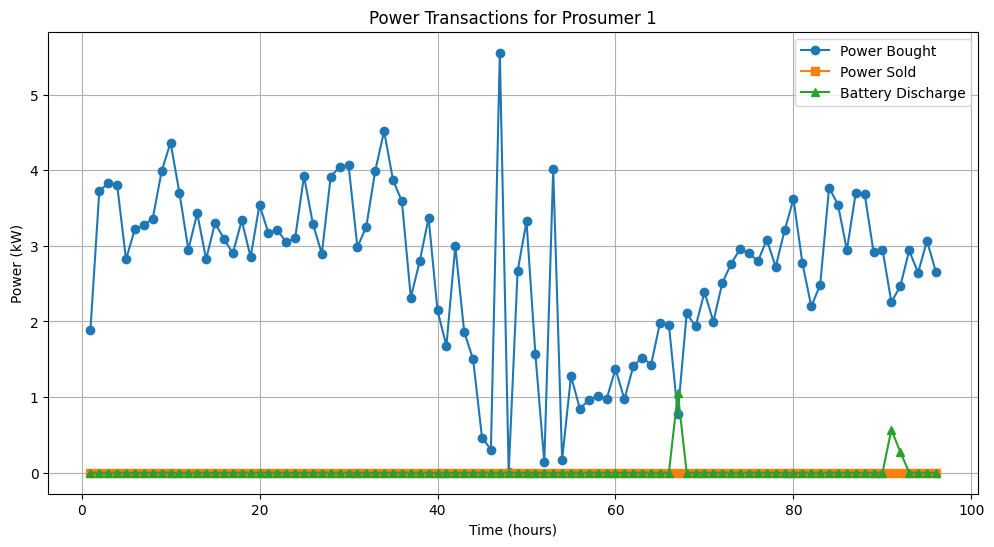

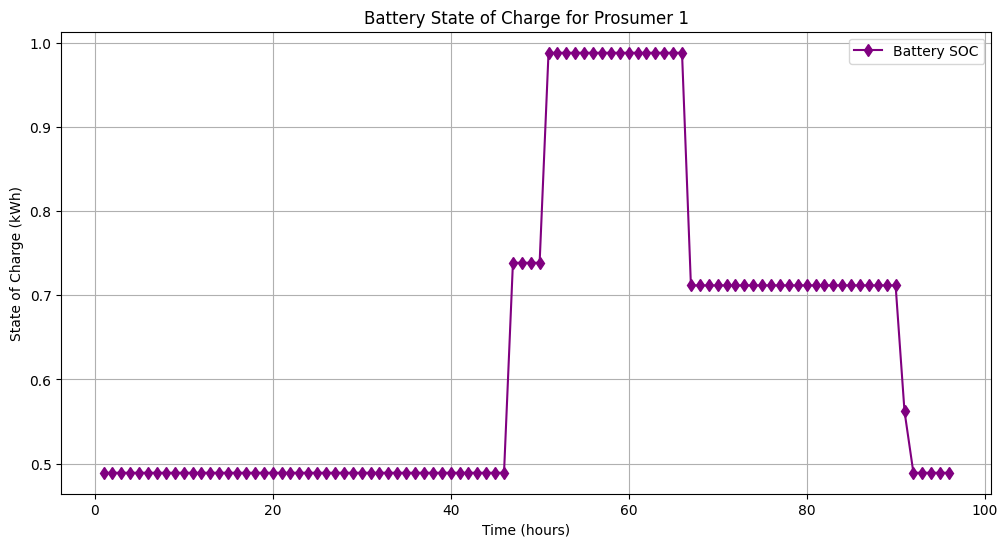

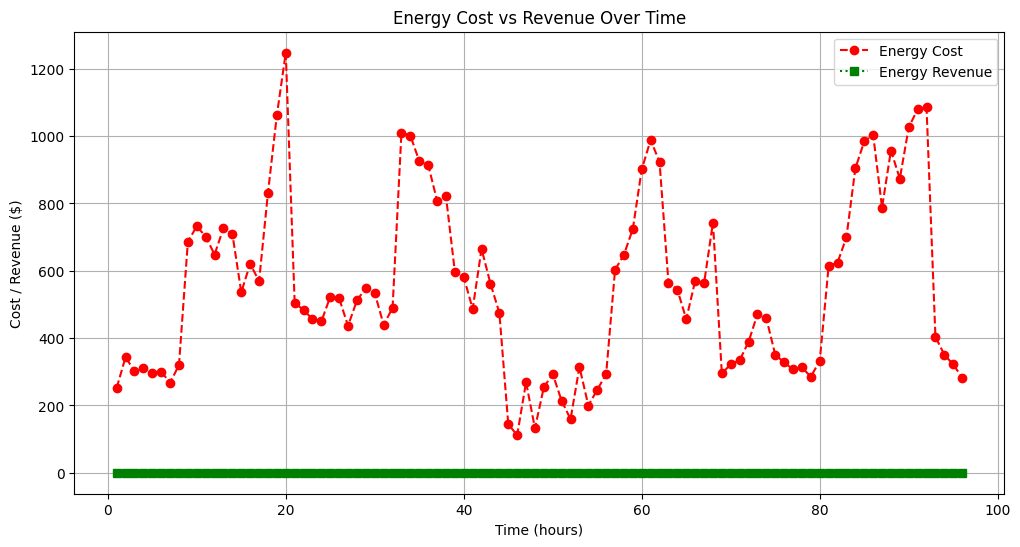

In [8]:
from pyomo.environ import value

P_buy_values = {(PL, T): value(instance.P_buy[PL, T]) for PL in instance.PL for T in instance.T}
P_sell_values = {(PL, T): value(instance.P_sell[PL, T]) for PL in instance.PL for T in instance.T}
""" P_peer_values = {
    (PL, PL1, T): value(instance.P_peer[PL, PL1, T]) for PL in instance.PL for PL1 in instance.PL for T in instance.T
    } """
P_dch_values = {(PL, T): value(instance.P_ESS_dch[PL, T]) for PL in instance.PL for T in instance.T}

# Print values   model.P_ESS_dch[PL, T]
print("P_buy values:")
for (PL, T), val in P_buy_values.items():
    print(f"Prosumer {PL}, Hour {T}: {val}")

print("\nP_sell values:")
for (PL, T), val in P_sell_values.items():
    print(f"Prosumer {PL}, Hour {T}: {val}")




import matplotlib.pyplot as plt

# Convert extracted values to a DataFrame for easier visualization
df_buy = pd.DataFrame(P_buy_values.values(), index=P_buy_values.keys(), columns=["P_buy"])
df_sell = pd.DataFrame(P_sell_values.values(), index=P_sell_values.keys(), columns=["P_sell"])
df_dch = pd.DataFrame(P_dch_values.values(), index=P_dch_values.keys(), columns=["P_ESS_dch"])

# Plot Power Buying and Selling Trends for a Specific Prosumer
prosumer_id = 1  # Change this to analyze different prosumers

plt.figure(figsize=(12, 6))
plt.plot(df_buy.xs(prosumer_id, level=0), label="Power Bought", marker="o")
plt.plot(df_sell.xs(prosumer_id, level=0), label="Power Sold", marker="s")
plt.plot(df_dch.xs(prosumer_id, level=0), label="Battery Discharge", marker="^")

plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.title(f"Power Transactions for Prosumer {prosumer_id}")
plt.legend()
plt.grid()
plt.show()


P_ESS_s_values = {(PL, T): value(instance.P_ESS_s[PL, T]) for PL in instance.PL for T in instance.T}
df_soc = pd.DataFrame(P_ESS_s_values.values(), index=P_ESS_s_values.keys(), columns=["SOC"])

plt.figure(figsize=(12, 6))
plt.plot(df_soc.xs(prosumer_id, level=0), label="Battery SOC", color="purple", marker="d")

plt.xlabel("Time (hours)")
plt.ylabel("State of Charge (kWh)")
plt.title(f"Battery State of Charge for Prosumer {prosumer_id}")
plt.legend()
plt.grid()
plt.show()


import seaborn as sns

""" # Convert P_peer_values into a DataFrame
df_peer = pd.DataFrame(P_peer_values.values(), index=P_peer_values.keys(), columns=["P_peer"])
df_peer = df_peer.unstack(level=1).fillna(0)  # Reshape for heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(df_peer["P_peer"].T, cmap="coolwarm", annot=True, fmt=".2f")
plt.xlabel("Receiving Prosumer")
plt.ylabel("Sending Prosumer")
plt.title("Peer-to-Peer Energy Exchange Heatmap")
plt.show() """




# Compute costs and revenues
costs = {t: instance.Cbuys[t] * sum(value(instance.P_buy[PL, t]) for PL in instance.PL) for t in instance.T}
revenues = {t: instance.Csells[t] * sum(value(instance.P_sell[PL, t]) for PL in instance.PL) for t in instance.T}

# Convert to DataFrame
df_cost = pd.DataFrame({"Cost": costs, "Revenue": revenues})

plt.figure(figsize=(12, 6))
plt.plot(df_cost["Cost"], label="Energy Cost", color="red", linestyle="--", marker="o")
plt.plot(df_cost["Revenue"], label="Energy Revenue", color="green", linestyle=":", marker="s")

plt.xlabel("Time (hours)")
plt.ylabel("Cost / Revenue ($)")
plt.title("Energy Cost vs Revenue Over Time")
plt.legend()
plt.grid()
plt.show()